In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
import cv2 as cv

# TODO: Export new requirements with pandas, ipykernel
# pip install opencv-python==3.4.5.20
# pip install pandas==0.24.0


In [2]:
data_folder = 'render_outputoutput'
# find any image file in the data folder and its subfolders
image_paths = glob.glob(os.path.join(data_folder, '**/image.png'), recursive=True)

def get_params_from_path(path):
  skin_id = re.search(r'skin_(\d+)', path).group(1)
  skin_id = int(skin_id)
  hair_model = re.search(r'hairModel_(-?\d+)', path).group(1)
  hair_model = int(hair_model)
  mel = re.search(r'mel_(\d+\.\d+)', path).group(1)
  mel = float(mel)
  return {'skin_id': skin_id, 'hair_model': hair_model, 'mel': mel, 'img': path}

df = pd.DataFrame([get_params_from_path(path) for path in image_paths])
df['contains_hair'] = df['hair_model'] != -1

,hair_model,img,mel,skin_id,contains_hair
0,-1,render_outputoutput/skin_051/hairModel_-01/mel...,0.31,51,False
4,29,render_outputoutput/skin_051/hairModel_029/mel...,0.31,51,True


(-0.5, 1023.5, 1023.5, -0.5)

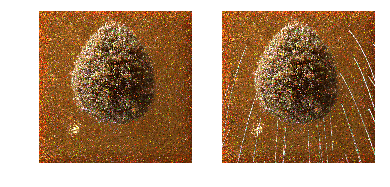

In [3]:
pair = df[(df['skin_id'] == 51) & (df['mel'] == 0.31)]
display(pair)

# Show images side by side
plt.subplot(1, 2, 1)
img1 = cv.imread(pair.iloc[0]['img'])
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
img2 = cv.imread(pair.iloc[1]['img'])
plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
plt.axis('off')

In [4]:
# resize
img1 = cv.resize(img1, (512, 512))
img2 = cv.resize(img2, (512, 512))

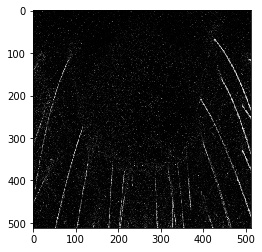

In [5]:
img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img2_gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
diff = cv.absdiff(img1_gray, img2_gray)
plt.imshow(diff, cmap='gray')

In [6]:
def dull_razor(image, kernel_size=(9, 9), blur_size=(3, 3), inpaint_radius=6, invert_blackhat=False):
    """
    Reads an image, crops it, and applies the Dull Razor method to remove hair.

    Parameters:
    image: np.array
        Image to be cleaned
    kernel_size: tuple
        Size of the kernel for the black hat filter
    blur_size: tuple
        Size of the Gaussian blur
    inpaint_radius: int
        Radius of the inpainting algorithm
    invert_blackhat: bool
        Invert the black hat filter, useful for when hair is lighter than the skin.
    """    
    # Convert to grayscale
    gray_scale = cv.cvtColor(image, cv.COLOR_RGB2GRAY)

    if invert_blackhat:
        gray_scale = cv.bitwise_not(gray_scale)
    
    # Apply black hat filter
    kernel = cv.getStructuringElement(cv.MORPH_RECT, kernel_size)
    blackhat = cv.morphologyEx(gray_scale, cv.MORPH_BLACKHAT, kernel)
    
    # Apply Gaussian blur
    bhg = cv.GaussianBlur(blackhat, blur_size, cv.BORDER_DEFAULT)
    
    # Threshold to create mask
    _, mask = cv.threshold(bhg, 10, 255, cv.THRESH_BINARY)
    
    # Inpainting
    cleaned_img = cv.inpaint(image, mask, inpaint_radius, cv.INPAINT_TELEA)
    
    return cleaned_img

In [7]:
# conda create --name hair-removal python=3.7
# conda activate hair-removal
# pip install -r requirements_dullrazor_analysis.txt

(512, 512, 3)


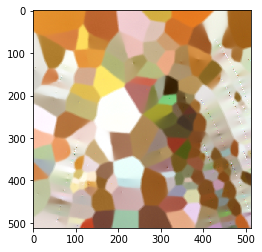

In [8]:
preprocessed = dull_razor(img2, invert_blackhat=False)
print(preprocessed.shape)
plt.imshow(cv.cvtColor(preprocessed, cv.COLOR_BGR2RGB))

(512, 512, 3)


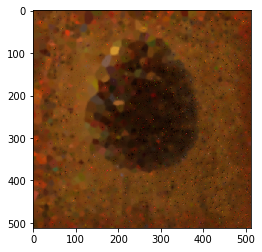

In [9]:
preprocessed = dull_razor(img2, invert_blackhat=True)
print(preprocessed.shape)
plt.imshow(cv.cvtColor(preprocessed, cv.COLOR_BGR2RGB))

The original DullRazor algorithm assumes that hair is dark and skin is light. This does not hold for people with dark skin or gray hair.

This notebook requires 

In [10]:
# check numpy version
print(np.__version__)

1.15.4


/home/marinbenc/miniconda3/envs/hair-removal/lib/python3.7/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 2 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/home/marinbenc/miniconda3/envs/hair-removal/lib/python3.7/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 1 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/home/marinbenc/miniconda3/envs/hair-removal/lib/python3.7/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 6 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


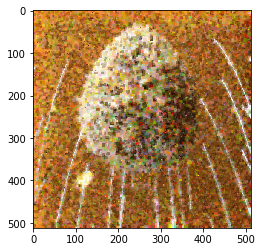

In [11]:
from hair_removal import remove_and_inpaint
hairless_image, steps = remove_and_inpaint(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
plt.imshow(hairless_image)

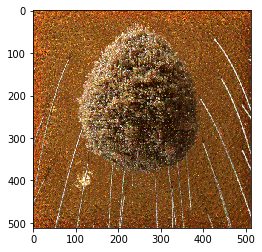

In [12]:
plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))